# Skin Cancer Detection Model

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1️⃣ Load & Preprocess Data

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Dataset directories
BASE_DIR = "/content/drive/MyDrive/Skin_Cancer"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
CLASS_MODE = 'binary'  # binary classification

# Data Augmentation and Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    shuffle=False
)


Found 11901 images belonging to 2 classes.
Found 2014 images belonging to 2 classes.


# 2️⃣ Exploratory Data Analysis (EDA)

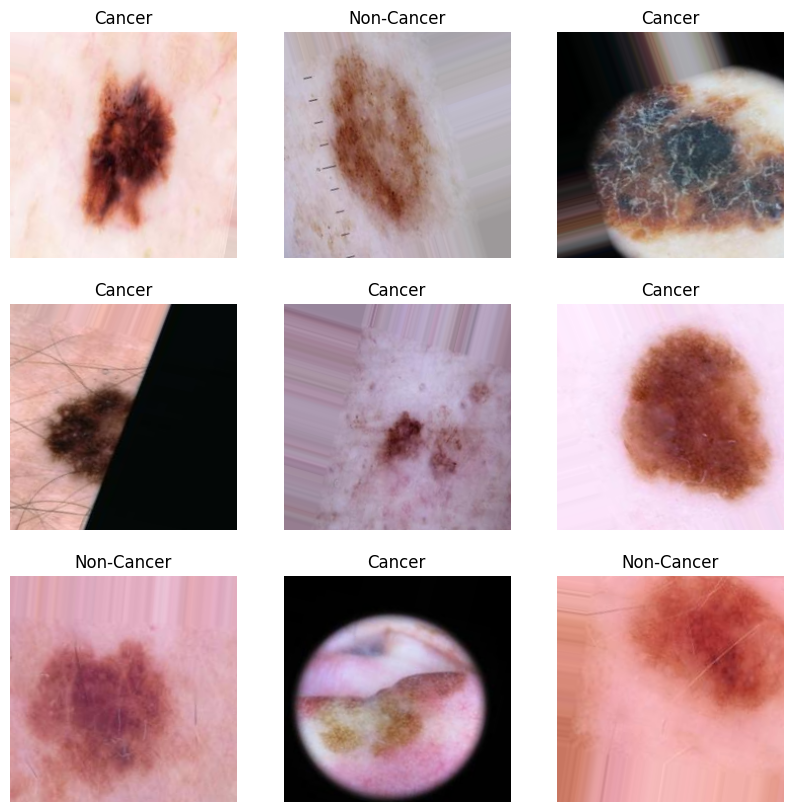

In [7]:
# Display some sample images from dataset
def plot_images(generator):
    images, labels = next(generator)  # Get a batch
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title("Cancer" if labels[i] == 1 else "Non-Cancer")
        plt.axis("off")
    plt.show()

# Plot Training Images
plot_images(train_generator)

# 3️⃣ Build CNN Model

In [8]:
# Model architecture
input_layer = Input(shape=(224, 224, 3))

x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,396,609 (169.36 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

# 4️⃣ Train & Evaluate Model

In [9]:
# Callbacks
checkpoint = ModelCheckpoint(
    filepath="/content/drive/MyDrive/skin_cancer_best_model.h5",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6644 - loss: 0.7063
Epoch 1: val_accuracy improved from -inf to 0.72782, saving model to /content/drive/MyDrive/skin_cancer_best_model.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 2410s 6s/step - accuracy: 0.6646 - loss: 0.7059 - val_accuracy: 0.7278 - val_loss: 0.4986 - learning_rate: 0.0010
Epoch 2/10
  1/371 ━━━━━━━━━━━━━━━━━━━━ 26:54 4s/step - accuracy: 0.8125 - loss: 0.5743

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.72782 to 0.74597, saving model to /content/drive/MyDrive/skin_cancer_best_model.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 89s 229ms/step - accuracy: 0.8125 - loss: 0.5743 - val_accuracy: 0.7460 - val_loss: 0.4826 - learning_rate: 0.0010
Epoch 3/10
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8002 - loss: 0.4351
Epoch 3: val_accuracy improved from 0.74597 to 0.82510, saving model to /content/drive/MyDrive/skin_cancer_best_model.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 1877s 5s/step - accuracy: 0.8002 - loss: 0.4351 - val_accuracy: 0.8251 - val_loss: 0.3987 - learning_rate: 0.0010
Epoch 4/10
  1/371 ━━━━━━━━━━━━━━━━━━━━ 26:29 4s/step - accuracy: 0.8438 - loss: 0.4329
Epoch 4: val_accuracy did not improve from 0.82510
371/371 ━━━━━━━━━━━━━━━━━━━━ 145s 379ms/step - accuracy: 0.8438 - loss: 0.4329 - val_accuracy: 0.8125 - val_loss: 0.4029 - learning_rate: 0.0010
Epoch 5/10
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8219 - loss: 0.4042
Epoch 5: val_accuracy did not improve from 0.82510
371/371 ━━━━━━━━━━━━━━━━━━━━ 1834s 5s/step - accuracy: 0.8219 - loss: 0.4042 - val_accuracy: 0.8090 - val_loss: 0.4052 - learning_rate: 0.0010
Epoch 6/10
  1/371 ━━━━━━━━━━━━━━━━━━━━ 22:05 4s/step - accuracy: 0.8750 - loss: 0.3199
Epoch 6: val_accuracy did not improve from 0.82510

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
371/371 ━━━━━━━━━━━━━━━━━━━━ 82s 211ms/step - accuracy: 0.8750 - loss: 0.3199 

371/371 ━━━━━━━━━━━━━━━━━━━━ 1788s 5s/step - accuracy: 0.8447 - loss: 0.3638 - val_accuracy: 0.8548 - val_loss: 0.3369 - learning_rate: 3.0000e-04
Epoch 8/10
  1/371 ━━━━━━━━━━━━━━━━━━━━ 28:05 5s/step - accuracy: 0.8438 - loss: 0.2402
Epoch 8: val_accuracy improved from 0.85484 to 0.85534, saving model to /content/drive/MyDrive/skin_cancer_best_model.h5


371/371 ━━━━━━━━━━━━━━━━━━━━ 143s 373ms/step - accuracy: 0.8438 - loss: 0.2402 - val_accuracy: 0.8553 - val_loss: 0.3358 - learning_rate: 3.0000e-04
Epoch 9/10
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8436 - loss: 0.3532
Epoch 9: val_accuracy did not improve from 0.85534
371/371 ━━━━━━━━━━━━━━━━━━━━ 1877s 5s/step - accuracy: 0.8436 - loss: 0.3532 - val_accuracy: 0.8397 - val_loss: 0.3551 - learning_rate: 3.0000e-04
Epoch 10/10
  1/371 ━━━━━━━━━━━━━━━━━━━━ 22:10 4s/step - accuracy: 0.8438 - loss: 0.3122
Epoch 10: val_accuracy did not improve from 0.85534
371/371 ━━━━━━━━━━━━━━━━━━━━ 78s 201ms/step - accuracy: 0.8438 - loss: 0.3122 - val_accuracy: 0.8473 - val_loss: 0.3483 - learning_rate: 3.0000e-04


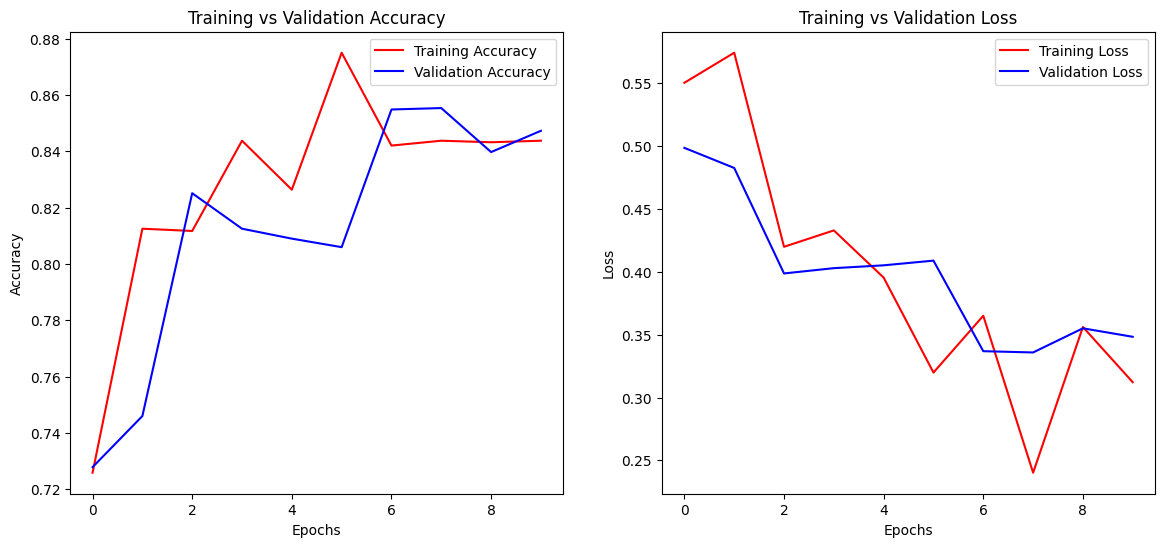

In [10]:
# Plot accuracy and loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='red')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 5️⃣ Evaluate Model Performance

63/63 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.8691 - loss: 0.2863
Test accuracy: 85.60%
63/63 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1000
           1       0.87      0.84      0.85      1014

    accuracy                           0.86      2014
   macro avg       0.86      0.86      0.86      2014
weighted avg       0.86      0.86      0.86      2014



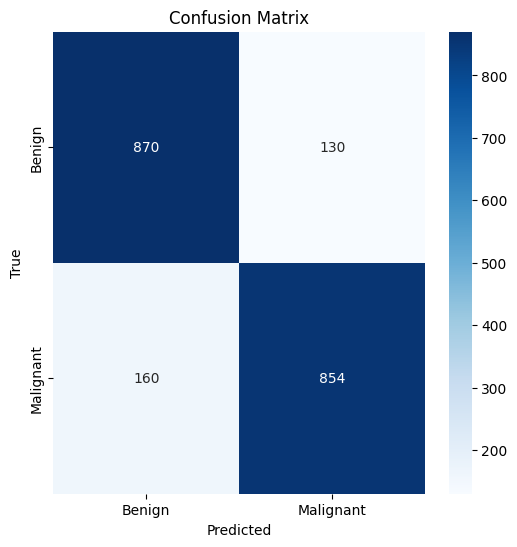

In [11]:
# Evaluate model
loss, accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {accuracy*100:.2f}%")

# Predict on test data - cover all test samples (ceil the steps)
import math

steps = math.ceil(test_generator.samples / test_generator.batch_size)
test_pred = model.predict(test_generator, steps=steps, verbose=1)

# Flatten predictions and apply threshold
test_pred_labels = (test_pred > 0.5).astype(int).flatten()

# Extract true labels (aligned using shuffle=False)
test_true_labels = test_generator.classes[:len(test_pred_labels)]


print("Classification Report:")
print(classification_report(test_true_labels, test_pred_labels))


cm = confusion_matrix(test_true_labels, test_pred_labels)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 6️⃣ Prediction System

In [12]:
# Prediction function
def predict_skin_cancer(model, img_path):
    from tensorflow.keras.preprocessing import image
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    class_label = "Malignant" if prediction > 0.5 else "Benign"
    plt.imshow(img)
    plt.title(f"Predicted: {class_label}")
    plt.axis("off")
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


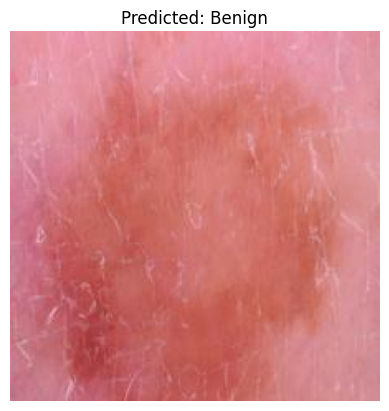

In [16]:
# Example usage
predict_skin_cancer(model, "/content/drive/MyDrive/Skin_Cancer/train/Benign/1002.jpg")

In [19]:
from google.colab import files
model_path = "/content/drive/MyDrive/skin_cancer_final.h5"

